# Explanaible AI - alibi - ALE - Accumulated Local Effects

**Links**

- alibi documentation main page: https://docs.seldon.io/projects/alibi/en/stable/
- alibi repo github: https://github.com/SeldonIO/alibi

- ALIBI ALE: https://docs.seldon.io/projects/alibi/en/stable/methods/ALE.html

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sklearn

import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px

# data
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

# models
from sklearn.linear_model import LinearRegression # lr
from sklearn.linear_model import Ridge # ridge
from sklearn.linear_model import Lasso # lasso
from sklearn.tree import DecisionTreeRegressor # tree
from sklearn.ensemble import GradientBoostingRegressor #gb
from sklearn.ensemble import RandomForestRegressor #rf
from xgboost import XGBRegressor # xgb
from  sklearn.neural_network import MLPRegressor # mlp

# alibi - ALE
from alibi.explainers import ALE
from alibi.explainers import plot_ale

### 1. Load data

In [2]:
##### load data
data_X, data_y = fetch_california_housing(return_X_y=True, as_frame=True)

##### joinn and rename dataset
data = data_X.copy()
data['Price'] = data_y

##### dropduplicates - some kind of plots in plotly return error with duplicated values
data = data.drop_duplicates()

##### delete outliers
percentil_lower = data.quantile(0.01)
percentil_upper = data.quantile(0.99)

data_raw = data[(data >= percentil_lower) & (data <= percentil_upper)]
data_raw.dropna(inplace = True)


##### split into train/test
target = 'Price'
list_features = list(set(data_raw.columns) - set([target]))

X_train, X_test, y_train, y_test = train_test_split(data_raw[list_features], 
                                                    data_raw[[target]], 
                                                    test_size = 0.2, 
                                                    random_state=42
                                                   )

In [3]:
list_features

['AveOccup',
 'Population',
 'AveBedrms',
 'AveRooms',
 'MedInc',
 'Longitude',
 'HouseAge',
 'Latitude']

In [4]:
target

'Price'

In [5]:
X_train.head()

,AveOccup,Population,AveBedrms,AveRooms,MedInc,Longitude,HouseAge,Latitude
5712,2.495957,926.0,1.094340,4.641509,4.1523,-118.24,34.0,34.22
15731,1.985000,1588.0,1.063750,3.771250,3.3882,-122.44,52.0,37.78
2894,3.346847,743.0,0.990991,4.135135,1.7292,-118.99,38.0,35.37
3333,2.284404,249.0,1.055046,4.770642,1.8417,-122.62,13.0,38.92
8410,4.721925,2649.0,1.026738,3.636364,2.3375,-118.35,33.0,33.93


### 2. Train models

#### 2.1 Linear regression

In [6]:
# train lr
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [7]:
# r2 score
r2_lr_train = lr.score(X_train, y_train)
r2_lr_test = lr.score(X_test, y_test)

print('r2_train: ', r2_lr_train)
print('r2_test: ', r2_lr_test)

r2_train:  0.6811276939092024
r2_test:  0.6813140626891636


#### 2.2 Random Forest Simple

In [8]:
# train rf simple
param_n_trees = 3
rf_simple = RandomForestRegressor(n_estimators = param_n_trees,
                                  random_state = 42,
                                 min_samples_split = 0.2,
                                    min_samples_leaf = 0.1)
                                   #max_depth = 2)
rf_simple.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=0.1, min_samples_split=0.2,
                      n_estimators=3, random_state=42)

In [9]:
# r2 score
r2_rf_simple_train = rf_simple.score(X_train, y_train)
r2_rf_simple_test = rf_simple.score(X_test, y_test)

print('r2_train: ', r2_rf_simple_train)
print('r2_test: ', r2_rf_simple_test)

r2_train:  0.45686524868931033
r2_test:  0.434027414718105


#### 2.3 Random Forest Default

In [10]:
# train rf default hiperparameters
rf_default = RandomForestRegressor(random_state = 42)
rf_default.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [11]:
# r2 score
r2_rf_default_train = rf_default.score(X_train, y_train)
r2_rf_default_test = rf_default.score(X_test, y_test)

print('r2_train: ', r2_rf_default_train)
print('r2_test: ', r2_rf_default_test)

r2_train:  0.9741946169466702
r2_test:  0.8100423362430826


### 3. ALIBI - Transform data - To use alibi it is neccesary the data need to be in format np.array()

In [12]:
# transform data into numpy array
X_train_numpy = X_train.to_numpy()
y_train_numpy = y_train.to_numpy()

X_test_numpy = X_test.to_numpy()
y_test_numpy = y_test.to_numpy()

### 4. ALIBI - ALE - Accumulated local effects

In [13]:
# list features
list_features

['AveOccup',
 'Population',
 'AveBedrms',
 'AveRooms',
 'MedInc',
 'Longitude',
 'HouseAge',
 'Latitude']

In [14]:
# target into format list
list_target = [target]

#### 4.1 Calculate ALE

In [15]:
# create estimators ALE
lr_ale = ALE(lr.predict, 
             feature_names = list_features, 
             target_names = list_target
            )
rf_ale = ALE(rf_default.predict, 
             feature_names = list_features, 
             target_names = list_target
            )

In [16]:
lr_ale

ALE(meta={
  'name': 'ALE',
  'type': ['blackbox'],
  'explanations': ['global'],
  'params': {
              'check_feature_resolution': True,
              'low_resolution_threshold': 10,
              'extrapolate_constant': True,
              'extrapolate_constant_perc': 10.0,
              'extrapolate_constant_min': 0.1}
            ,
  'version': '0.9.5'}
)

In [17]:
rf_ale

ALE(meta={
  'name': 'ALE',
  'type': ['blackbox'],
  'explanations': ['global'],
  'params': {
              'check_feature_resolution': True,
              'low_resolution_threshold': 10,
              'extrapolate_constant': True,
              'extrapolate_constant_perc': 10.0,
              'extrapolate_constant_min': 0.1}
            ,
  'version': '0.9.5'}
)

In [18]:
# Calculate values Accumulated local effects
lr_exp = lr_ale.explain(X_train_numpy)
rf_exp = rf_ale.explain(X_train_numpy)

#### 4.2 Plot ALE - all features

array([[<Axes: xlabel='AveOccup', ylabel='ALE'>,
        <Axes: xlabel='Population', ylabel='ALE'>,
        <Axes: xlabel='AveBedrms', ylabel='ALE'>,
        <Axes: xlabel='AveRooms', ylabel='ALE'>],
       [<Axes: xlabel='MedInc', ylabel='ALE'>,
        <Axes: xlabel='Longitude', ylabel='ALE'>,
        <Axes: xlabel='HouseAge', ylabel='ALE'>,
        <Axes: xlabel='Latitude', ylabel='ALE'>]], dtype=object)

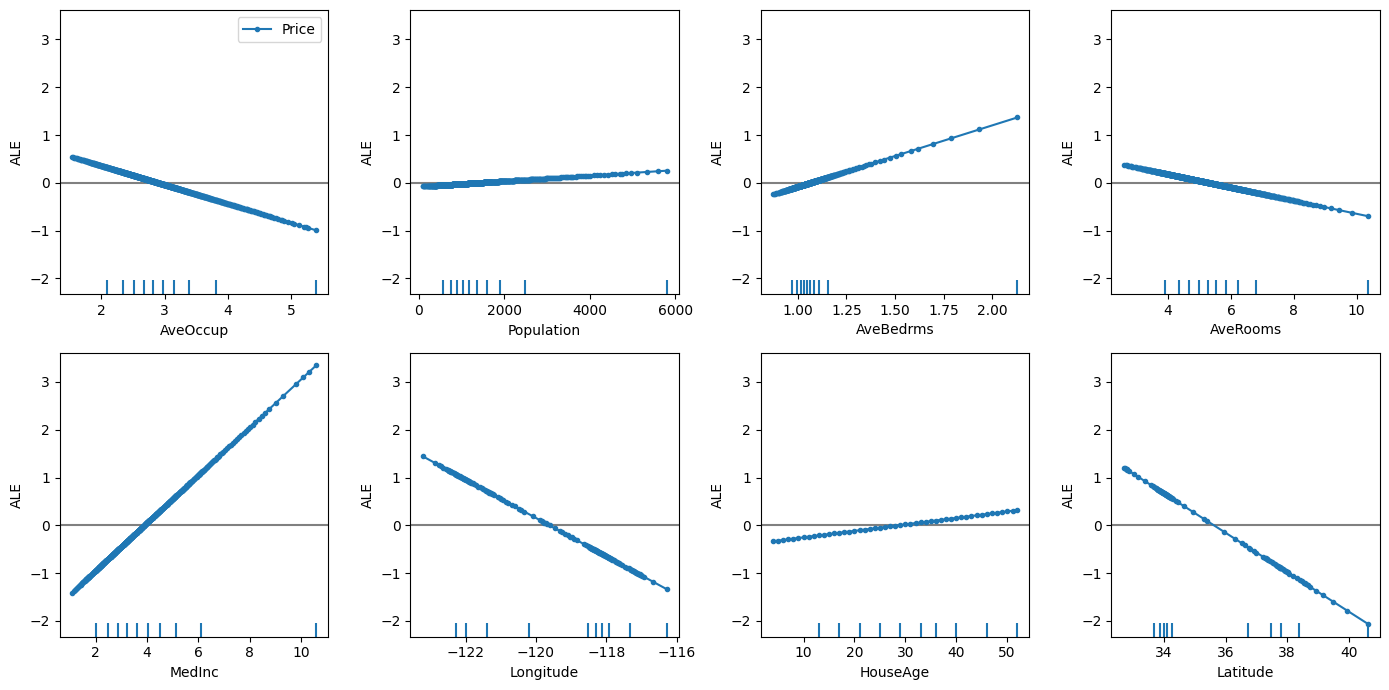

In [19]:
# plot ale LR
plot_ale(lr_exp, n_cols = 4, fig_kw={'figwidth':14, 'figheight': 7})

array([[<Axes: xlabel='AveOccup', ylabel='ALE'>,
        <Axes: xlabel='Population', ylabel='ALE'>,
        <Axes: xlabel='AveBedrms', ylabel='ALE'>,
        <Axes: xlabel='AveRooms', ylabel='ALE'>],
       [<Axes: xlabel='MedInc', ylabel='ALE'>,
        <Axes: xlabel='Longitude', ylabel='ALE'>,
        <Axes: xlabel='HouseAge', ylabel='ALE'>,
        <Axes: xlabel='Latitude', ylabel='ALE'>]], dtype=object)

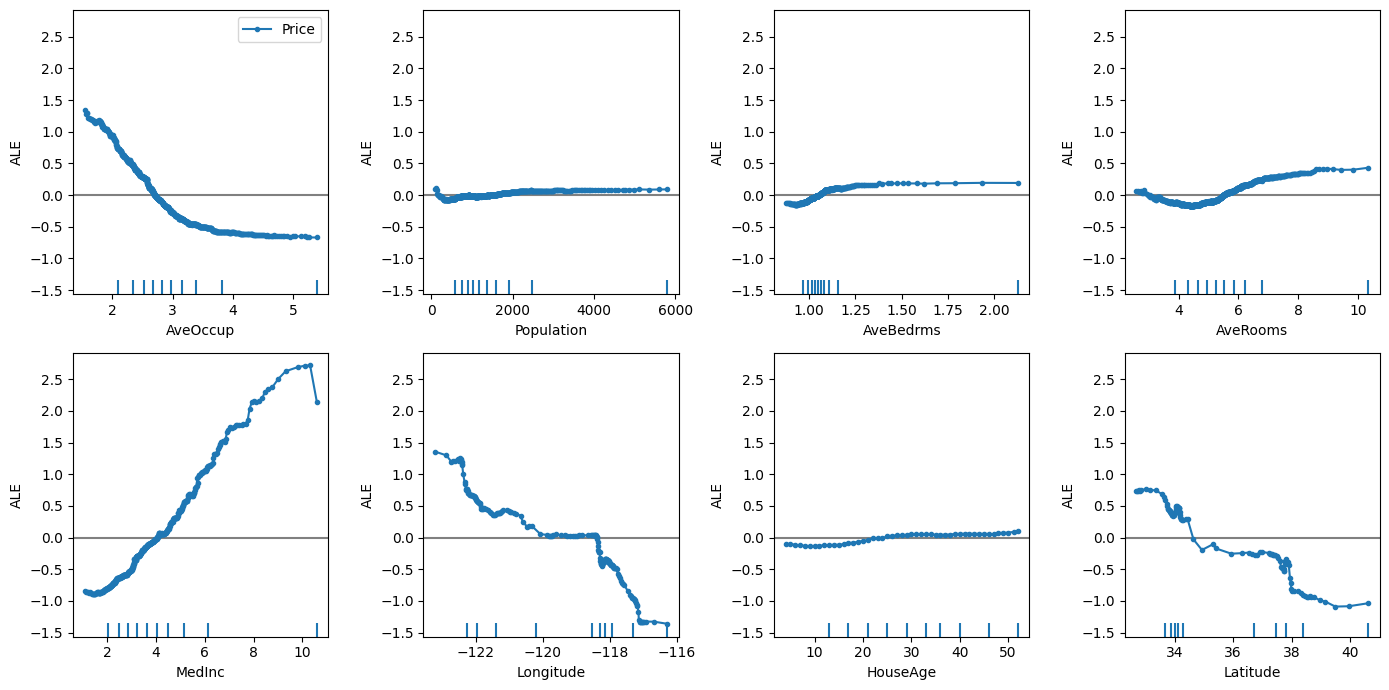

In [24]:
# plot ale RF
plot_ale(rf_exp, n_cols = 4, fig_kw={'figwidth':14, 'figheight': 7})

#### 4.3 Plot ALE - plot specific features

array([[<Axes: xlabel='MedInc', ylabel='ALE'>,
        <Axes: xlabel='Longitude', ylabel='ALE'>]], dtype=object)

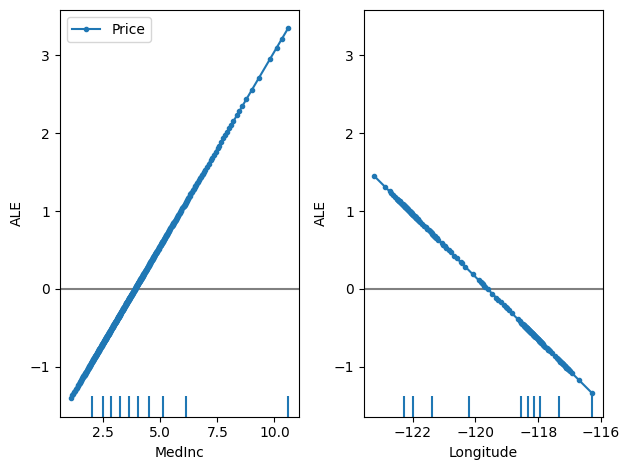

In [27]:
# plot two features
plot_ale(lr_exp, 
         features=['MedInc', 'Longitude']
        )

array([[<Axes: xlabel='MedInc', ylabel='ALE'>]], dtype=object)

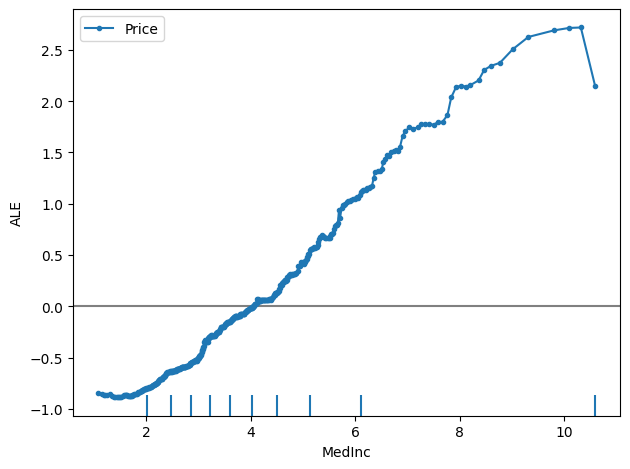

In [28]:
# plot one feature
plot_ale(rf_exp, 
         features=['MedInc']
        )

#### 4.4 Plot ALE - subplots - compare multiple models - all features

array([[<Axes: xlabel='MedInc', ylabel='ALE'>]], dtype=object)

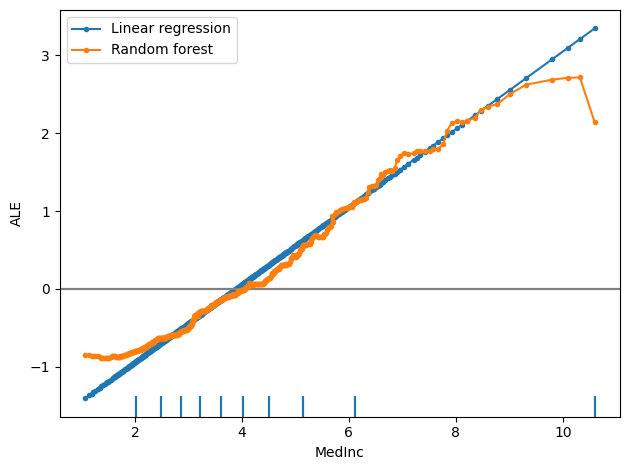

In [31]:
fig, ax = plt.subplots()

plot_ale(lr_exp, features=['MedInc'], ax=ax, line_kw={'label': 'Linear regression'})
plot_ale(rf_exp, features=['MedInc'], ax=ax, line_kw={'label': 'Random forest'})

#### 4.5 Plot ALE - subplots - compare multiple models - specific features

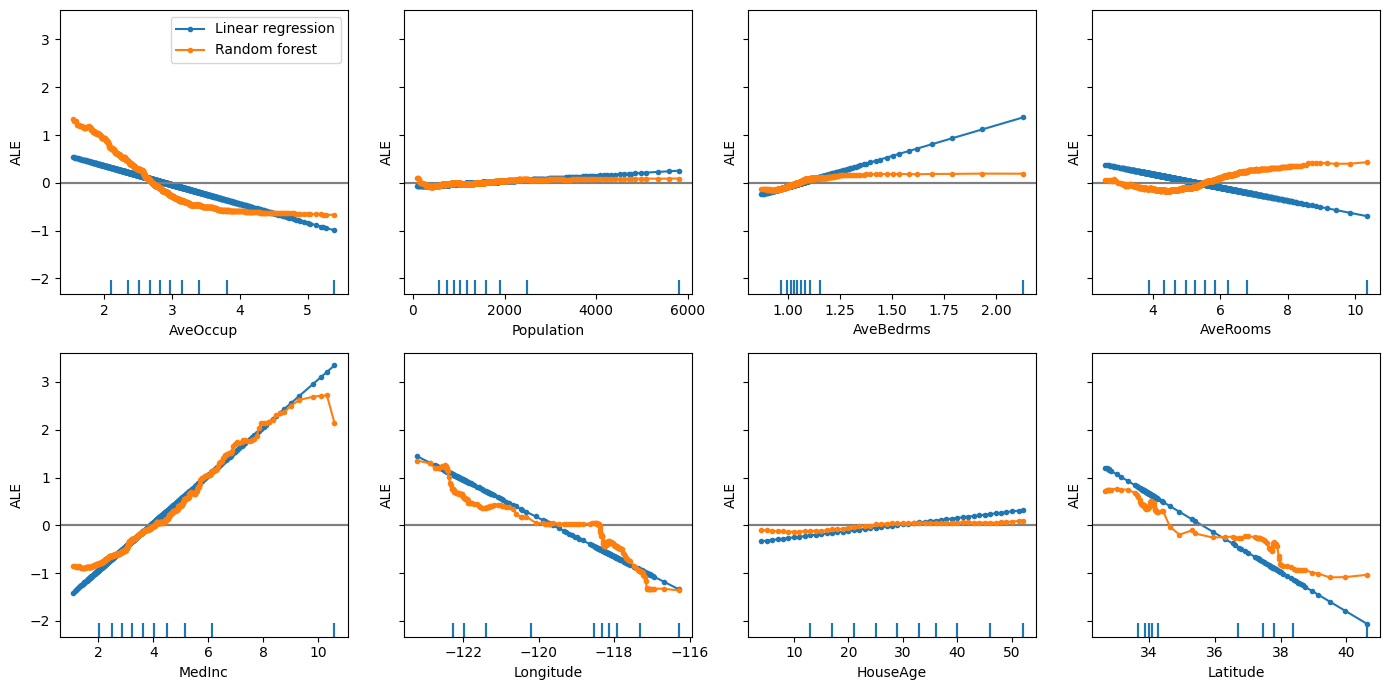

In [29]:
fig, ax = plt.subplots(2, 4, sharey='all')

# plot ale lr
plot_ale(lr_exp, ax=ax, fig_kw={'figwidth':14, 'figheight': 7},
         line_kw={'label': 'Linear regression'})

# plot ale rf
plot_ale(rf_exp, ax=ax, line_kw={'label': 'Random forest'})